In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from datetime import datetime
import dateparser
import os
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('retina')
%matplotlib inline
# імпртуємо пропет та інші бібліотеки
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()
#plt.style.use('fivethirtyeight')

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

#reading file, not standart delimeter, providing it(;) to pandas

df=pd.read_csv('../datasets/household_power_consumption.txt', delimiter=';')
df1=pd.read_csv('../datasets/household_power_consumption.txt', delimiter=';', index_col=["Date"], parse_dates=["Date"])

#rewriting to read from excel
#df.to_csv('../temp/timeser.csv',encoding='utf-16', sep='\t', index=False)
df.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [1]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_true, y_pred):
    print("R2 score = ", r2_score(y_true, y_pred))
    print("MAE = ", mean_absolute_error(y_true, y_pred))
    print("MedianAE = ", median_absolute_error(y_true, y_pred))
    print("MSE = ", mean_squared_error(y_true, y_pred))
    print("MAPE = ", mean_absolute_percentage_error(y_true, y_pred))

In [58]:
df_trying=df.copy(deep=True)
df_trying=df_trying.apply(pd.to_numeric, errors='ignore')
df_trying.dtypes




Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [60]:
df_trying=df_trying.apply(pd.to_numeric, errors='coerce')
df_trying.dtypes

Date                     float64
Time                     float64
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [61]:
df_compressing=df.copy(deep=True).drop(columns=['Sub_metering_1','Sub_metering_2','Sub_metering_3'])

#introduction to datetime
df_compressing['Datetime']=df_compressing['Date'] + ' '+ df_compressing['Time']
#df_compressing['Datetime'] = datetime.strptime(df_compressing['Datetime'], '%d/%m/%y %H:%M:%S')


#drop unnnecessary column for datetime
df_compressing=df_compressing.drop(columns=['Date', 'Time'])


df_compressing[['Global_active_power','Global_reactive_power']]=df_compressing[['Global_active_power','Global_reactive_power']].apply(pd.to_numeric, errors='coerce')

#Calculating total power, like vectorizing sum
#in scalar, formula will be like:
df_compressing['Total_power']=(df_compressing['Global_active_power']**2+df_compressing['Global_reactive_power']**2)**0.5

#drop unnnecessary column for datetime
df_compressing=df_compressing.drop(columns=['Global_active_power','Global_reactive_power'])


df_compressing=df_compressing[['Datetime','Total_power', 'Voltage','Global_intensity']]

#df_compressing['Global_active_power']=df_compressing['Global_active_power'].apply(pd.to_numeric, errors='coerce')
df_compressing['Datetime']=df_compressing['Datetime'].apply(pd.to_datetime, errors='coerce')
df_compressing=df_compressing.set_index(df_compressing.columns[0])

df_compressing=df_compressing['Total_power']
# df_compressing.describe()

df_compressing
#exec_time=5m 7sec


KeyboardInterrupt: 

In [ ]:
df_compressing.describe()

count    2.049280e+06
mean     1.109554e+00
std      1.051854e+00
min      7.600000e-02
25%      3.319036e-01
50%      6.340000e-01
75%      1.538519e+00
max      1.112336e+01
Name: Total_power, dtype: float64

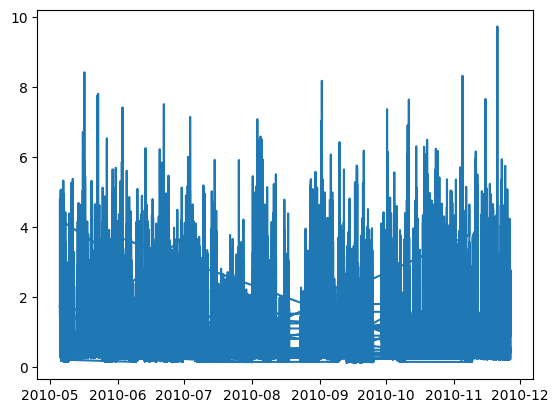

In [ ]:
df_graph=df_compressing.loc['2010-05-05 10:00:00':'2010-11-26 21:02:00']
plt.plot(df_graph)

In [5]:
df_real=df1.copy(deep=True)




df_real[['Global_active_power','Global_reactive_power']]=df_real[['Global_active_power','Global_reactive_power']].apply(pd.to_numeric, errors='coerce')

#Calculating total power, like vectorizing sum
#in scalar, formula will be like:
df_real['Total_power']=(df_real['Global_active_power']**2+df_real['Global_reactive_power']**2)**0.5

df_real=df_real.drop(columns= ['Time','Global_active_power','Global_reactive_power', 'Sub_metering_1','Sub_metering_2', 'Sub_metering_3','Voltage','Global_intensity'])
#df_real['Date']=df_real['Date'].apply(pd.to_datetime, errors='coerce')
df_real



Total_power
Date                   
2006-12-16     4.236671
2006-12-16     5.377704
2006-12-16     5.397025
2006-12-16     5.411335
2006-12-16     3.703828
...                 ...
2010-11-26     0.946000
2010-11-26     0.944000
2010-11-26     0.938000
2010-11-26     0.934000
2010-11-26     0.932000

[2075259 rows x 1 columns]

In [100]:
df_real=df_real.groupby(by=['Date']).mean()
#df_real.loc['2007-01-01']
df_real.info()
#print(df_real.dropna().count())
#print(df_real.count())




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total_power  1433 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


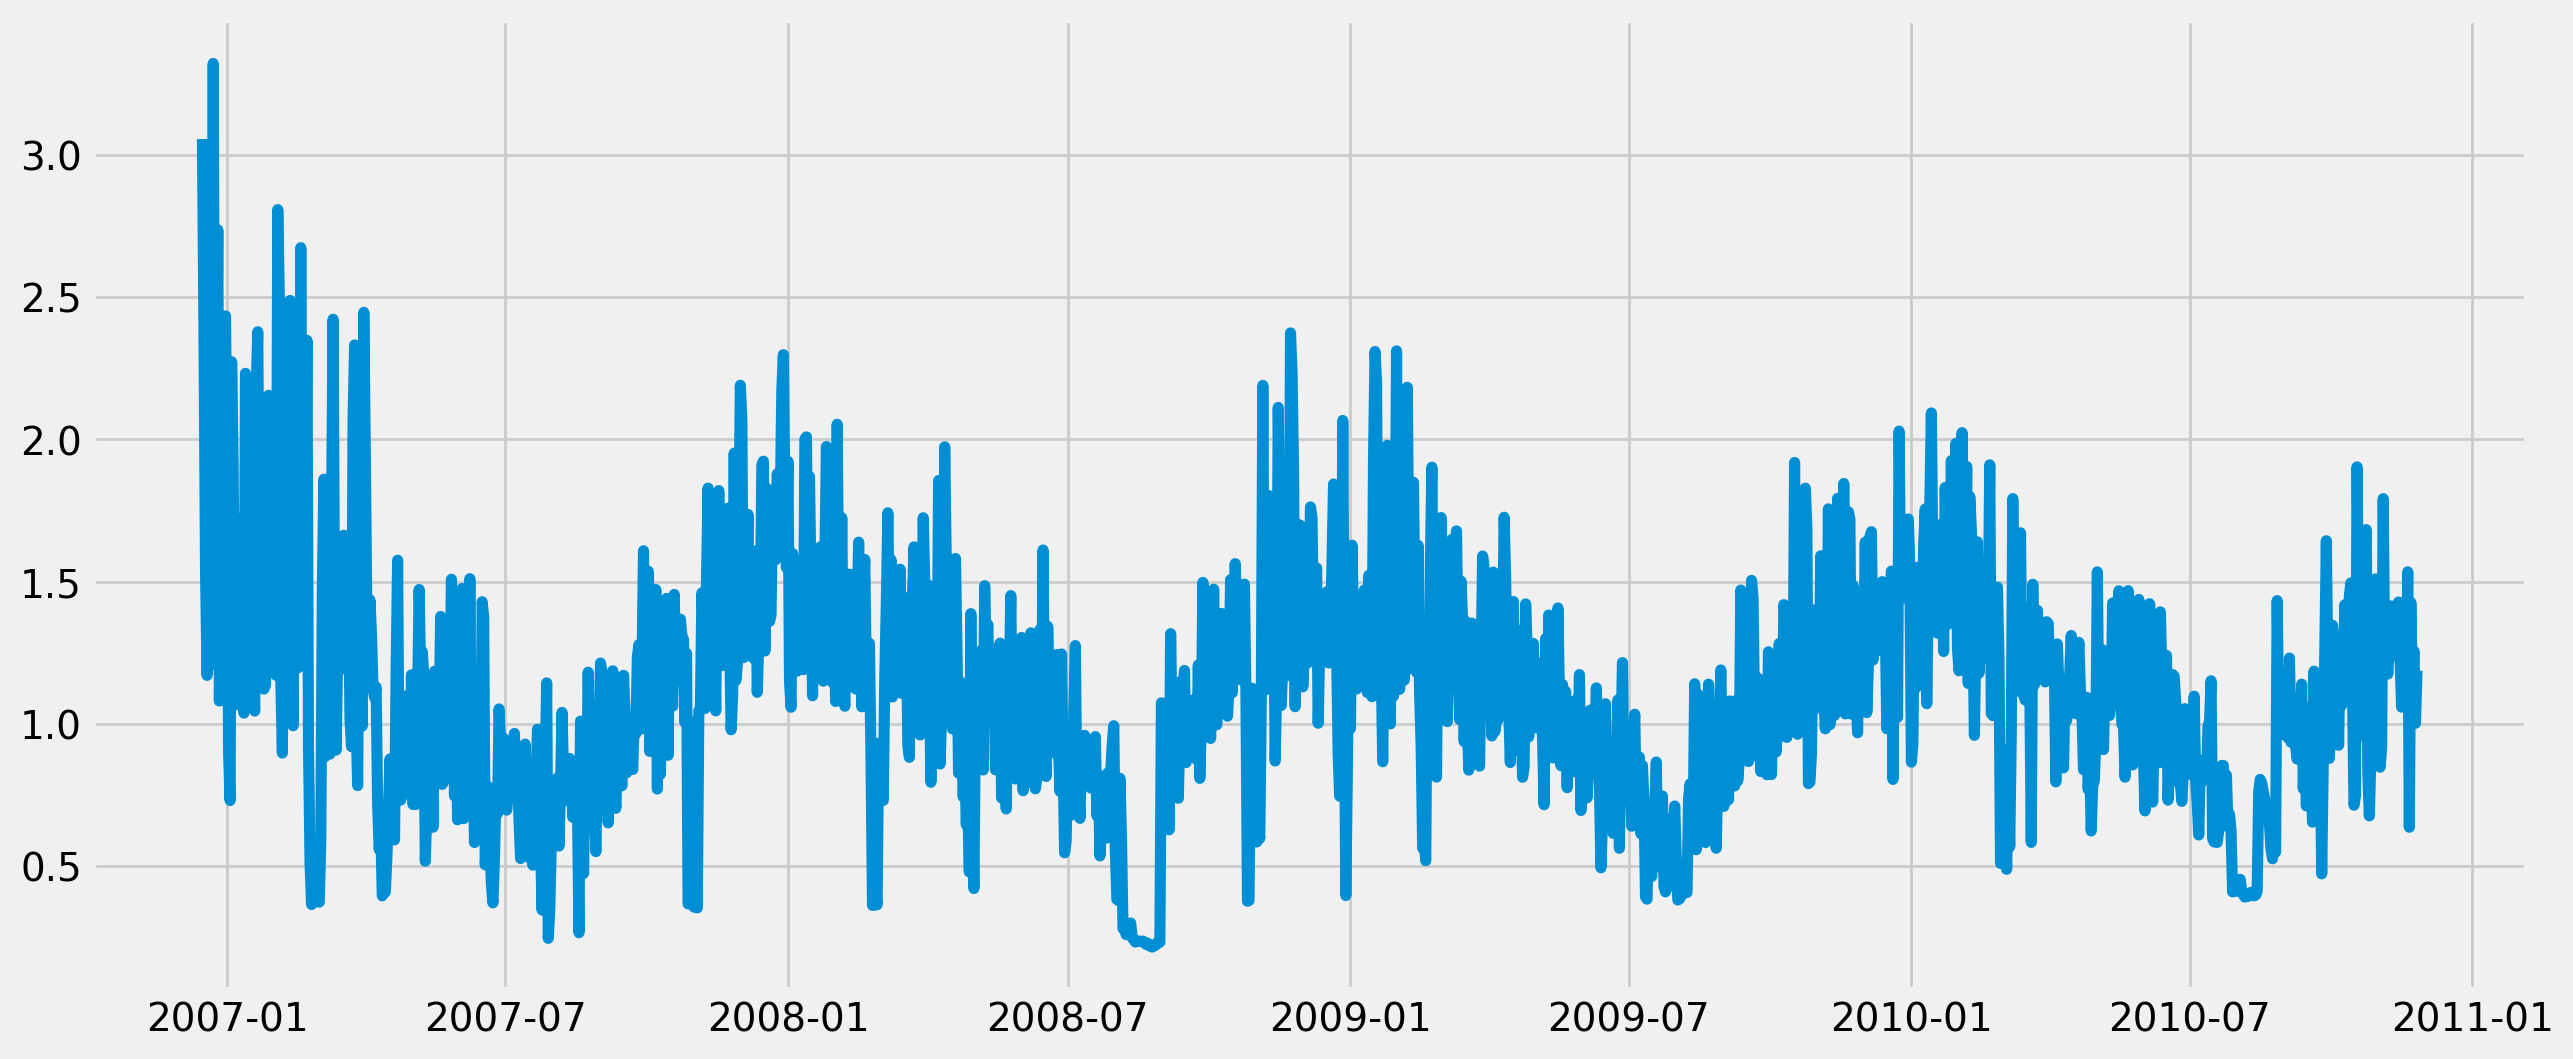

In [83]:
plt.figure(figsize=(14, 6))
plt.plot(df_real)
plt.show()

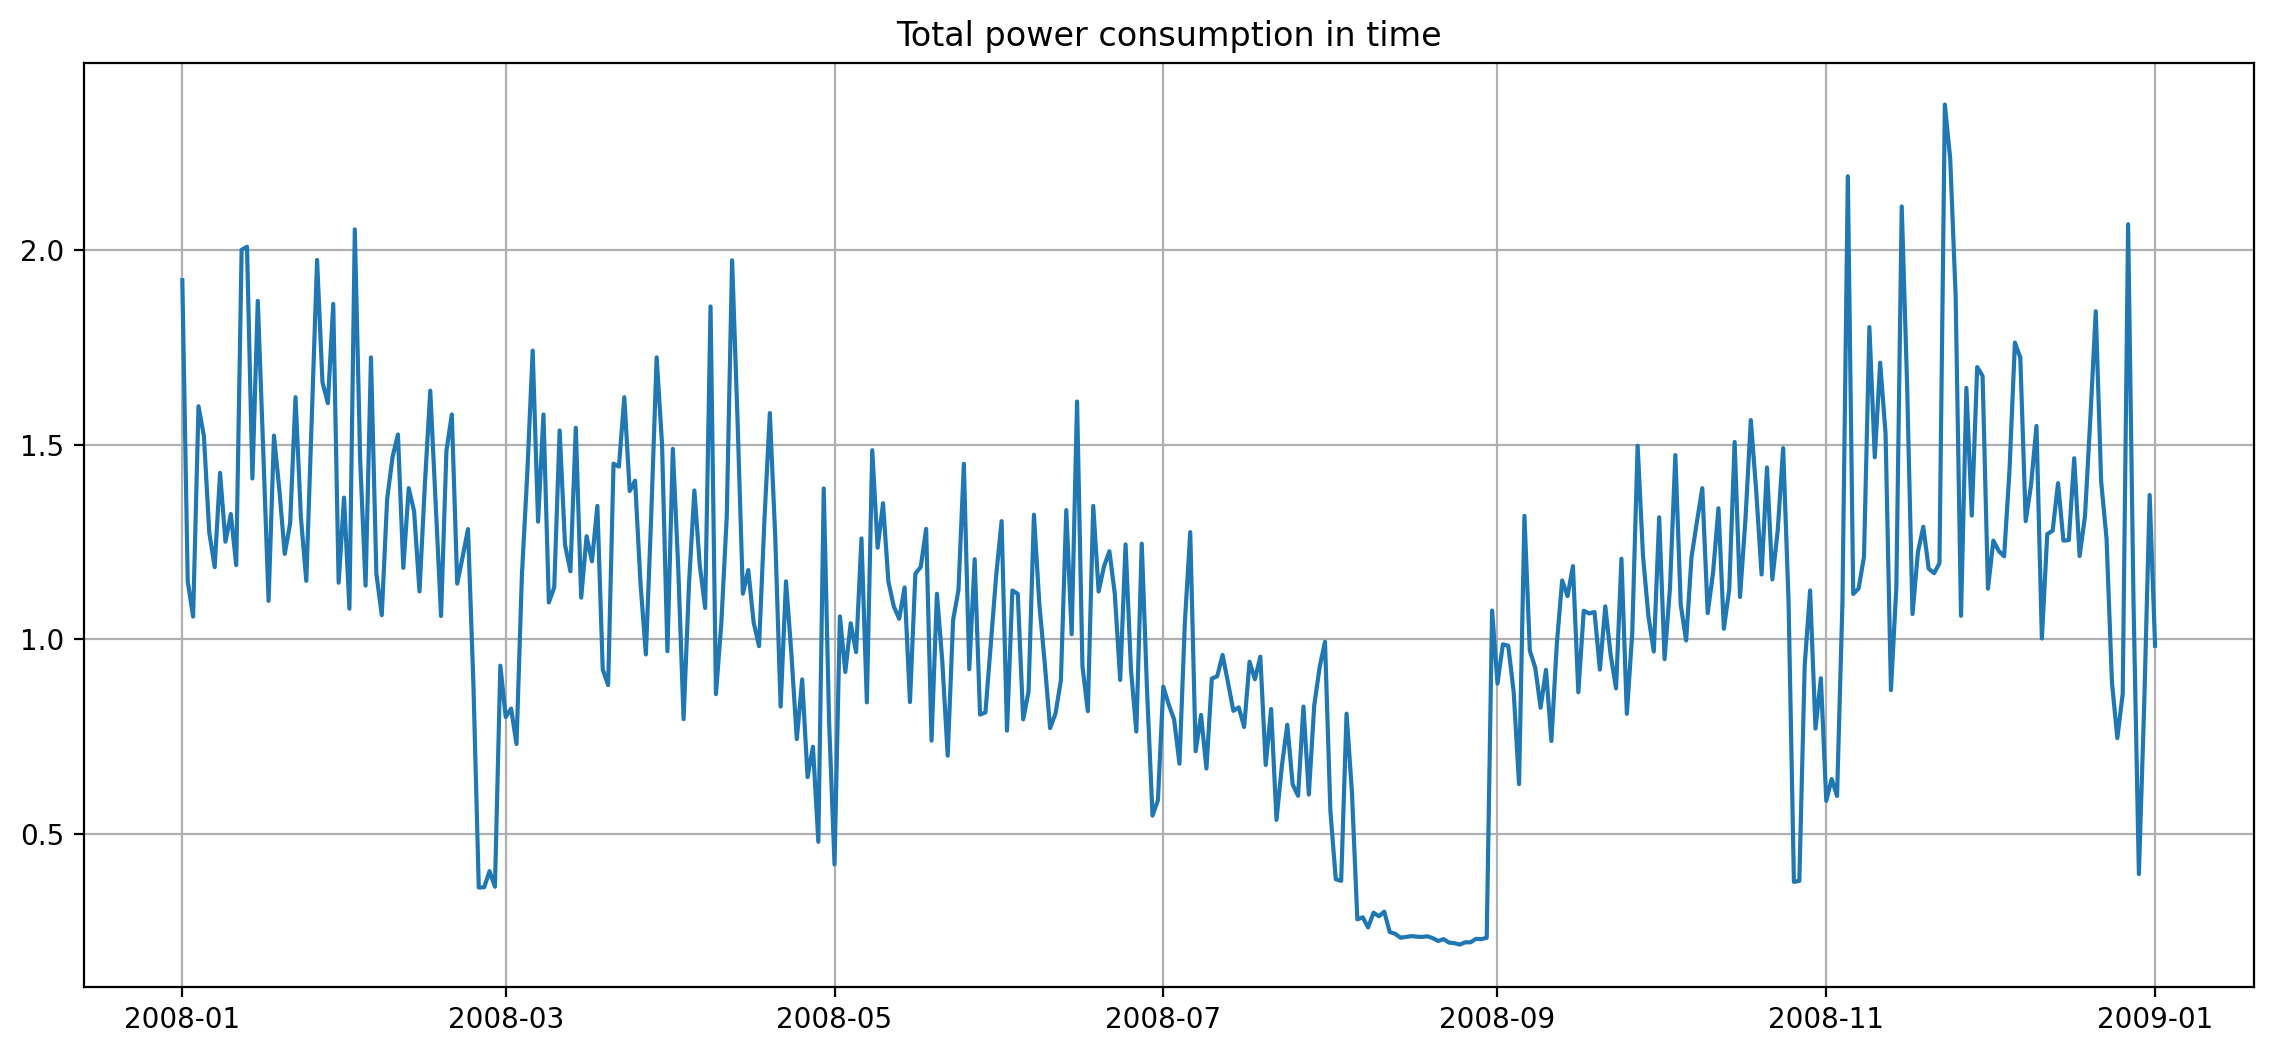

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(df_real.loc['01/01/2008':'01/01/2009'])
plt.title("Total power consumption in time")
plt.grid(True)
plt.show()

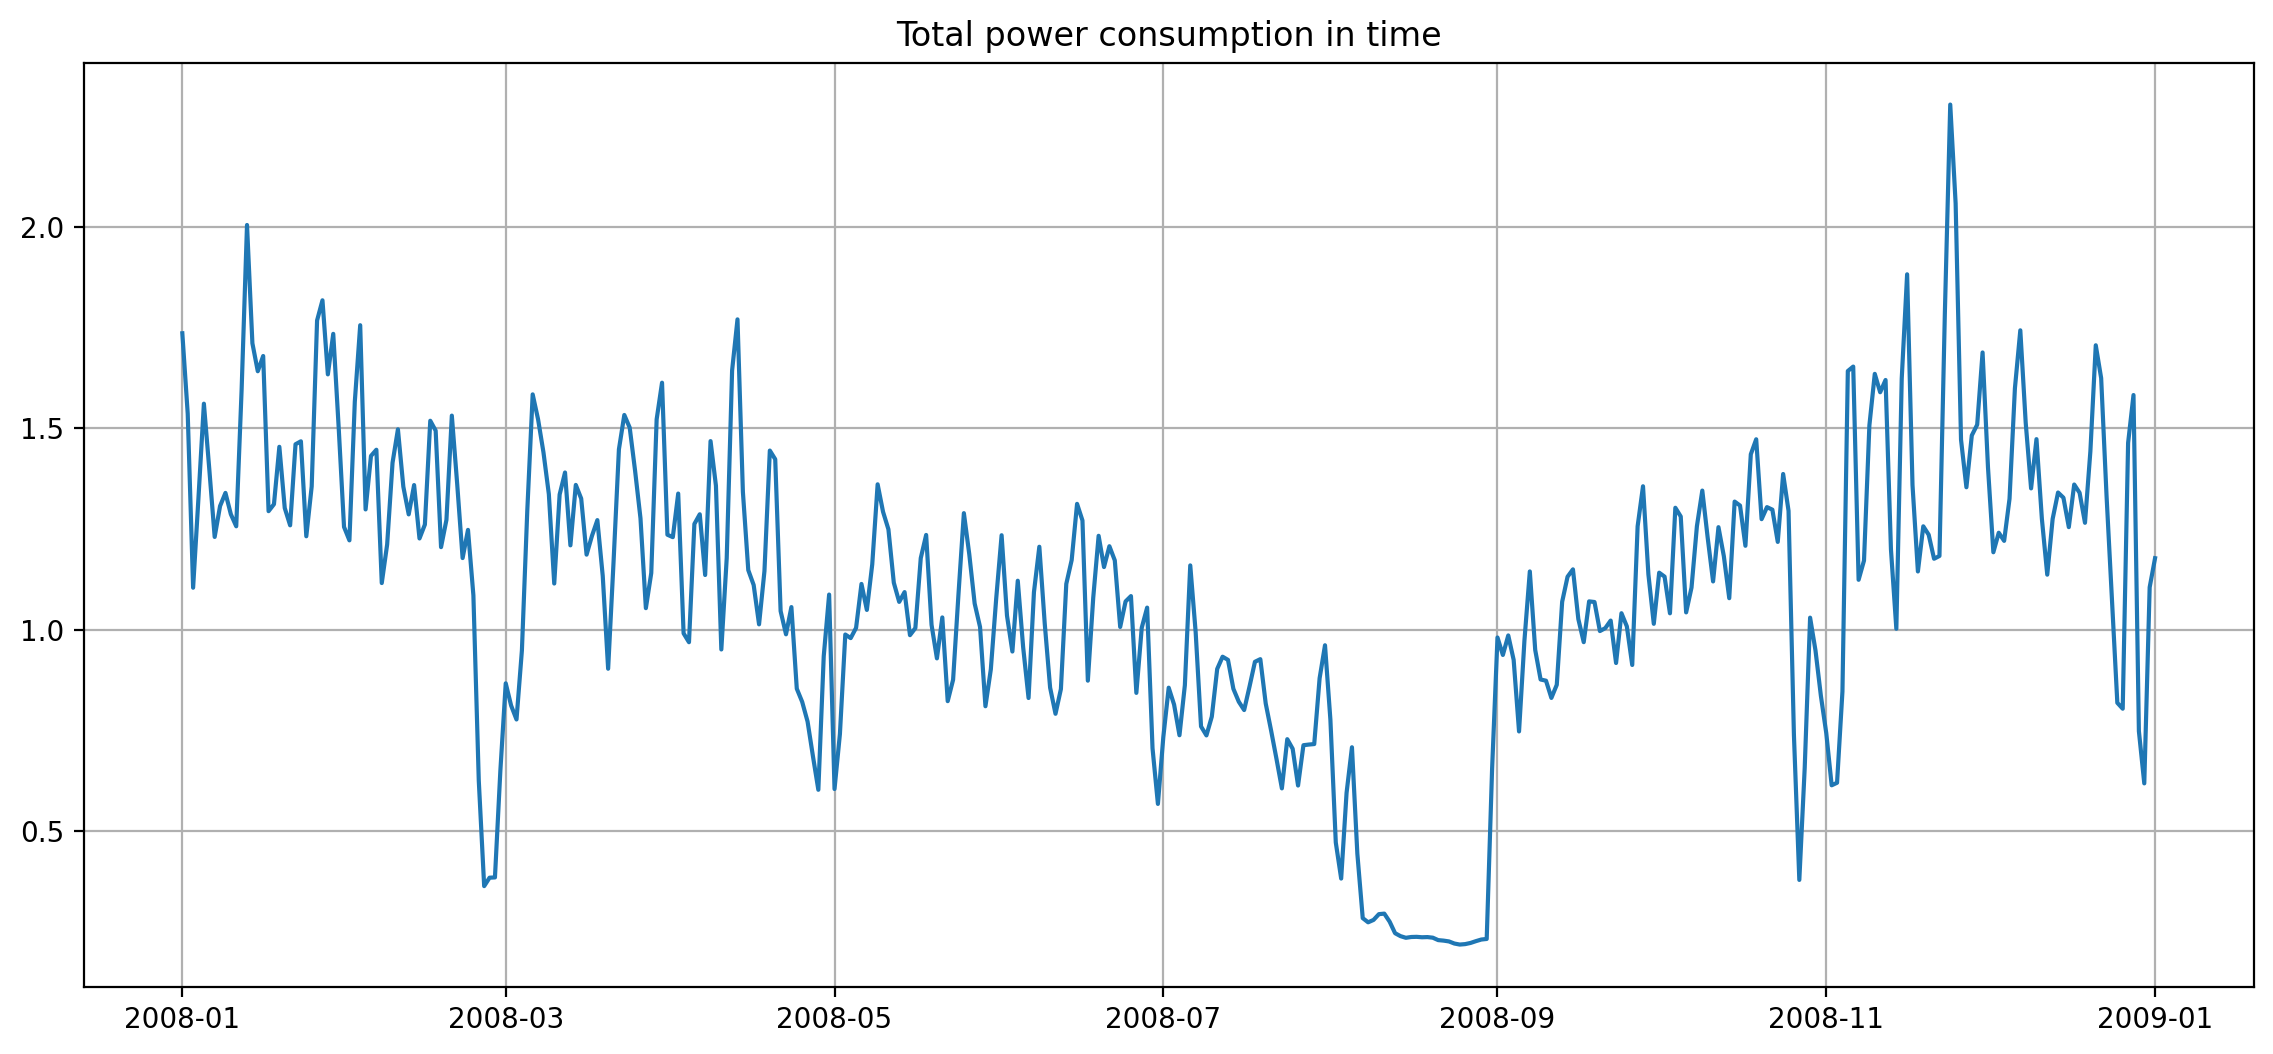

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(df_real.rolling(window=2).mean().loc['01/01/2008':'01/01/2009'])
plt.title("Total power consumption in time")
plt.grid(True)
plt.show()


In [3]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "purple", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    print_metrics(series[window:], rolling_mean[window:])

ValueError: Input contains NaN.

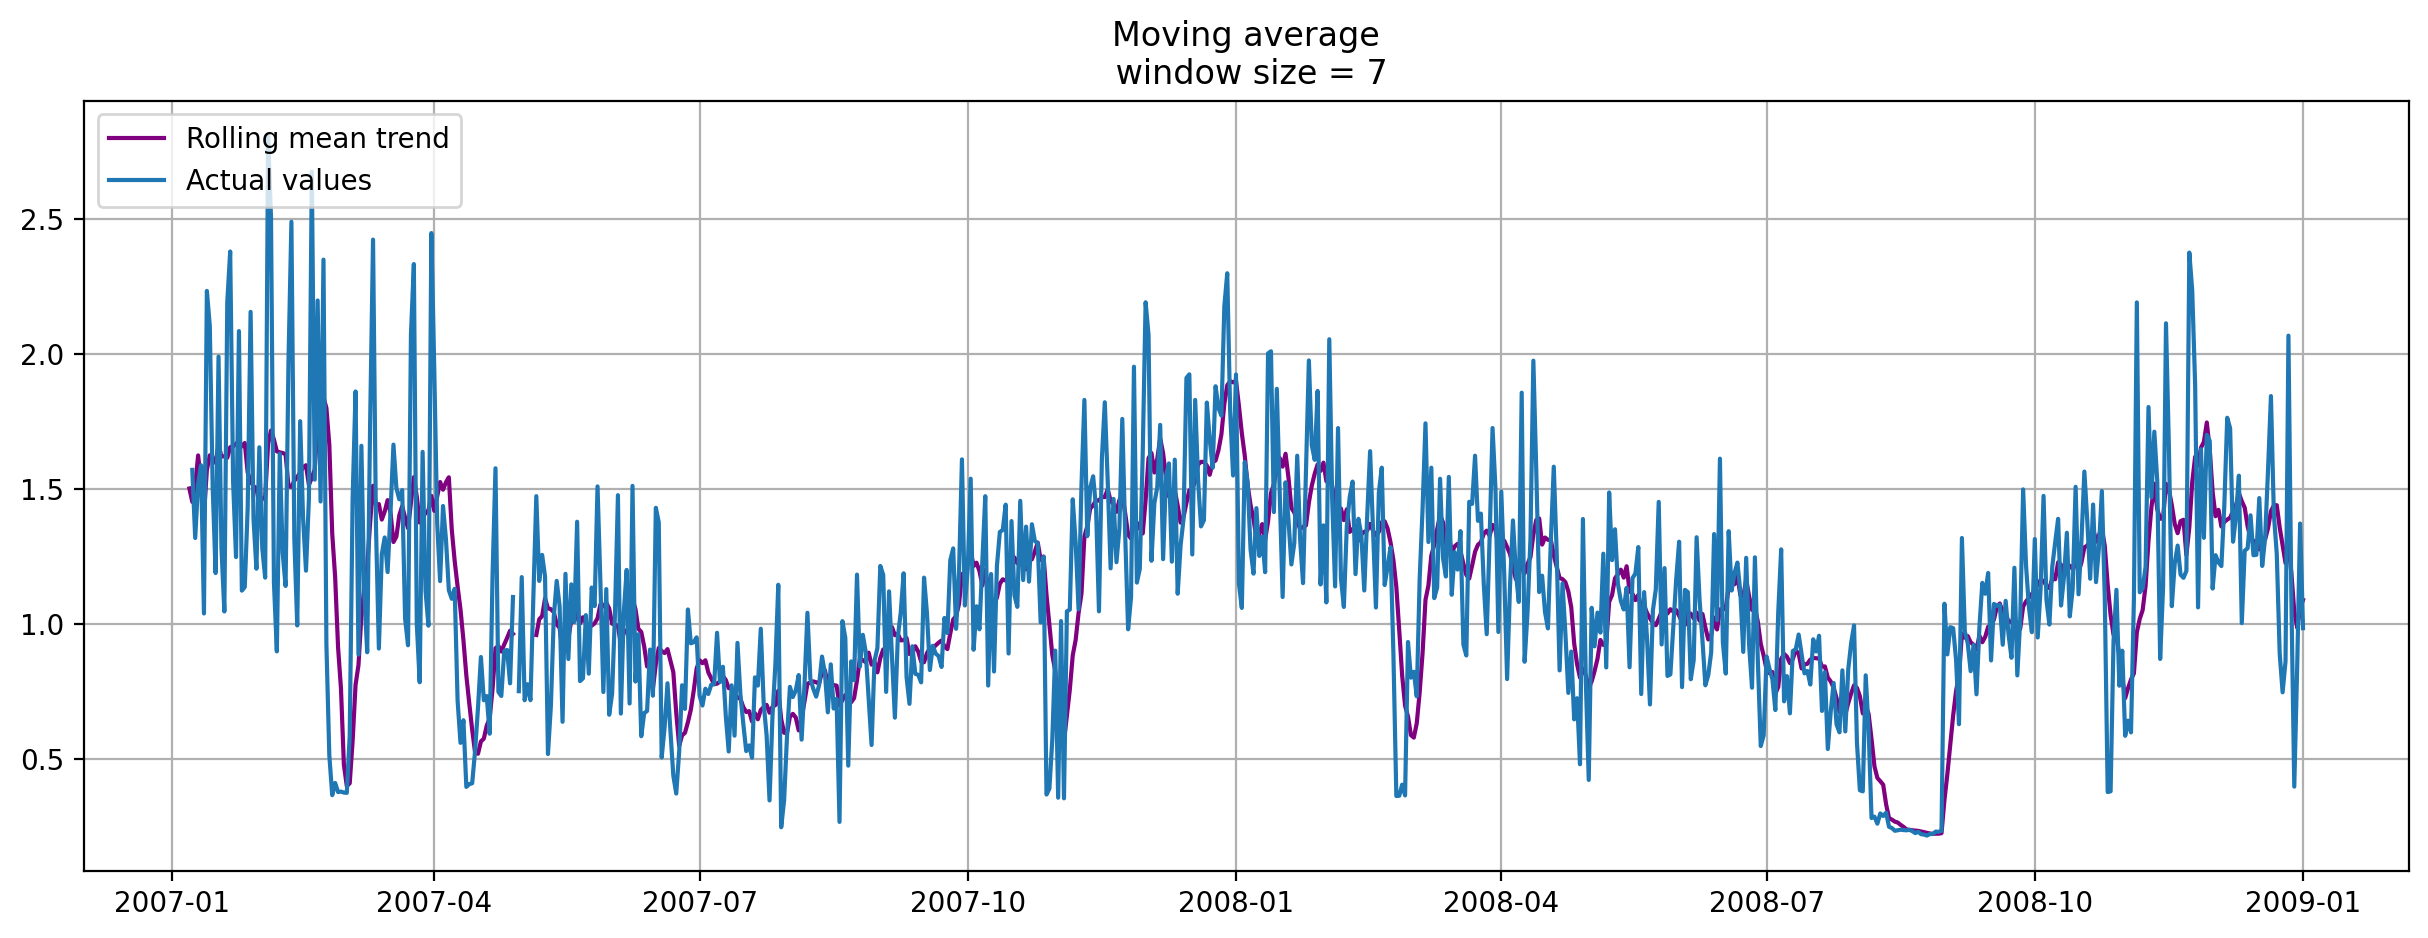

In [12]:
plotMovingAverage(df_real['01/01/2007': '01/01/2009'], 7)

In [91]:
print(df_real.info())
df_real=df_real.dropna()
print(df_real.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total_power  1433 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1433 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total_power  1433 non-null   float64
dtypes: float64(1)
memory usage: 22.4 KB
None


R2 score =  0.6741600353980324
MAE =  0.1851063889093526
MedianAE =  0.14034560635561627
MSE =  0.06456072242661941
MAPE =  18.142191986072646


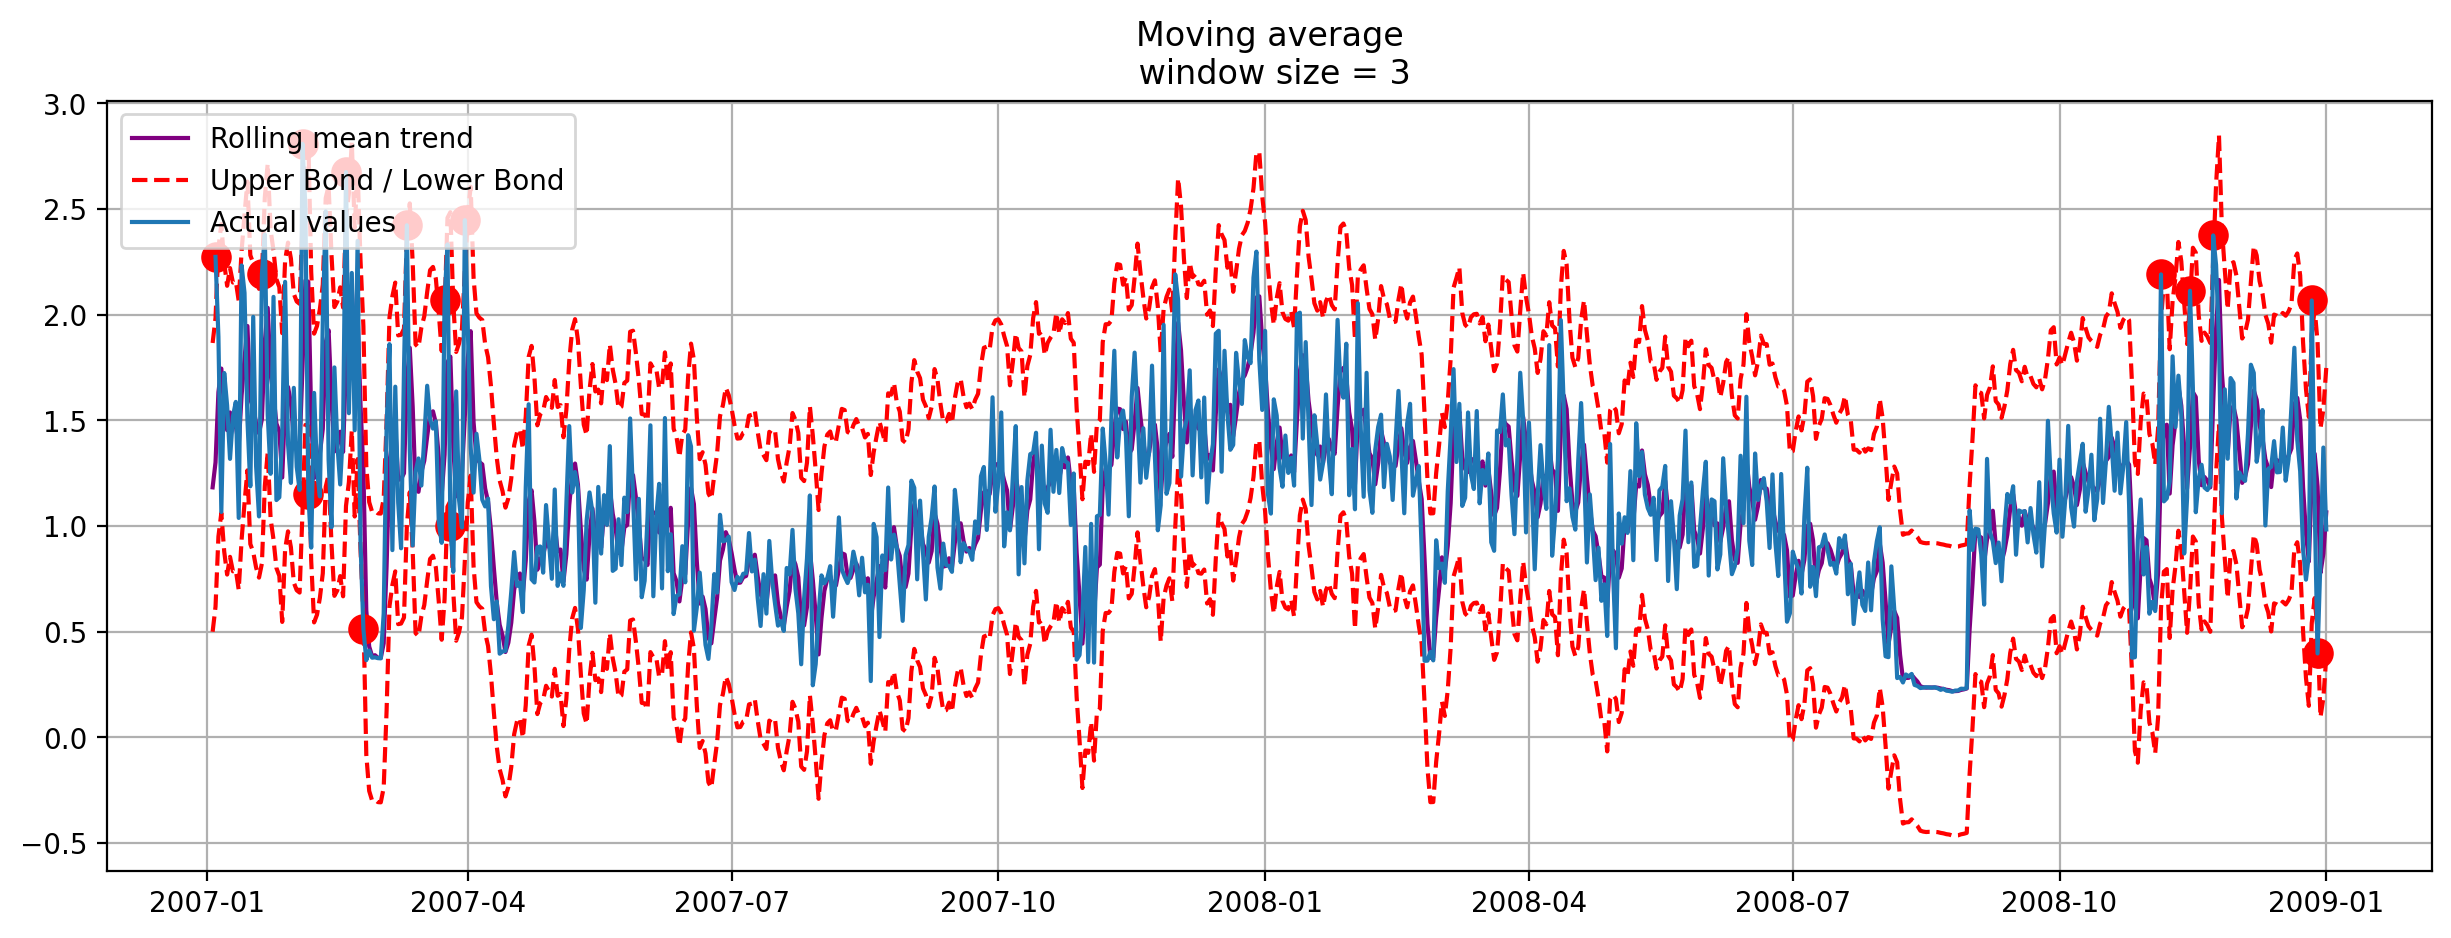

In [14]:
plotMovingAverage(df_real['01/01/2007': '01/01/2009'], 3,plot_intervals=True,plot_anomalies=True)

In [4]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += (series.iloc[-n - 1] * weights[n])/sum(weights)
    return float(result)

In [133]:
weighted_average(df_real, [0.25, 0.5, 0.75, 1])

1.138732424740363

In [15]:
# для того щоб працювала бібліотека Prophet треба щоб колонки мали особливу назву, час - ds а передбачення y
df_real = df_real.rename(columns={'Date': 'ds',
                        'Total_power': 'y'})


In [19]:
df_real.reset_index(name=['Date'])

TypeError: DataFrame.reset_index() got an unexpected keyword argument 'name'

In [5]:
df_prop=df.copy(deep=True)




df_prop[['Global_active_power','Global_reactive_power']]=df_prop[['Global_active_power','Global_reactive_power']].apply(pd.to_numeric, errors='coerce')

#Calculating total power, like vectorizing sum
#in scalar, formula will be like:
df_prop['Total_power']=(df_prop['Global_active_power']**2+df_prop['Global_reactive_power']**2)**0.5

df_prop=df_prop.drop(columns= ['Time','Global_active_power','Global_reactive_power', 'Sub_metering_1','Sub_metering_2', 'Sub_metering_3','Voltage','Global_intensity'])
#df_real['Date']=df_real['Date'].apply(pd.to_datetime, errors='coerce')
df_prop



Date  Total_power
0        16/12/2006     4.236671
1        16/12/2006     5.377704
2        16/12/2006     5.397025
3        16/12/2006     5.411335
4        16/12/2006     3.703828
...             ...          ...
2075254  26/11/2010     0.946000
2075255  26/11/2010     0.944000
2075256  26/11/2010     0.938000
2075257  26/11/2010     0.934000
2075258  26/11/2010     0.932000

[2075259 rows x 2 columns]

In [6]:
df_prop = df_prop.rename(columns={'Date': 'ds',
                        'Total_power': 'y'})
df_prop

ds         y
0        16/12/2006  4.236671
1        16/12/2006  5.377704
2        16/12/2006  5.397025
3        16/12/2006  5.411335
4        16/12/2006  3.703828
...             ...       ...
2075254  26/11/2010  0.946000
2075255  26/11/2010  0.944000
2075256  26/11/2010  0.938000
2075257  26/11/2010  0.934000
2075258  26/11/2010  0.932000

[2075259 rows x 2 columns]

In [9]:
df_prop['ds']=pd.to_datetime(df_prop['ds'])
df_prop

df_prop=df_prop.groupby(by=['ds']).mean()
#df_real.loc['2007-01-01']
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1433 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


In [10]:
print(df_prop.info())
df_prop=df_prop.dropna()
print(df_prop.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1433 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1433 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1433 non-null   float64
dtypes: float64(1)
memory usage: 22.4 KB
None


In [11]:
# намалюємо графік наших даних
ax = df_prop.set_index('ds').plot(figsize=(15, 8))
ax.set_ylabel('Power consumption ')
ax.set_xlabel('Date')

plt.show()

KeyError: "None of ['ds'] are in the columns"

In [22]:
df_prop.reset_index(inplace=True)


In [18]:
# increm=[]
# increm=np.array([i for i in range(len(df_prop))])
# print(increm)
# increm[0]==int(increm[0])


[   0    1    2 ... 1430 1431 1432]


True

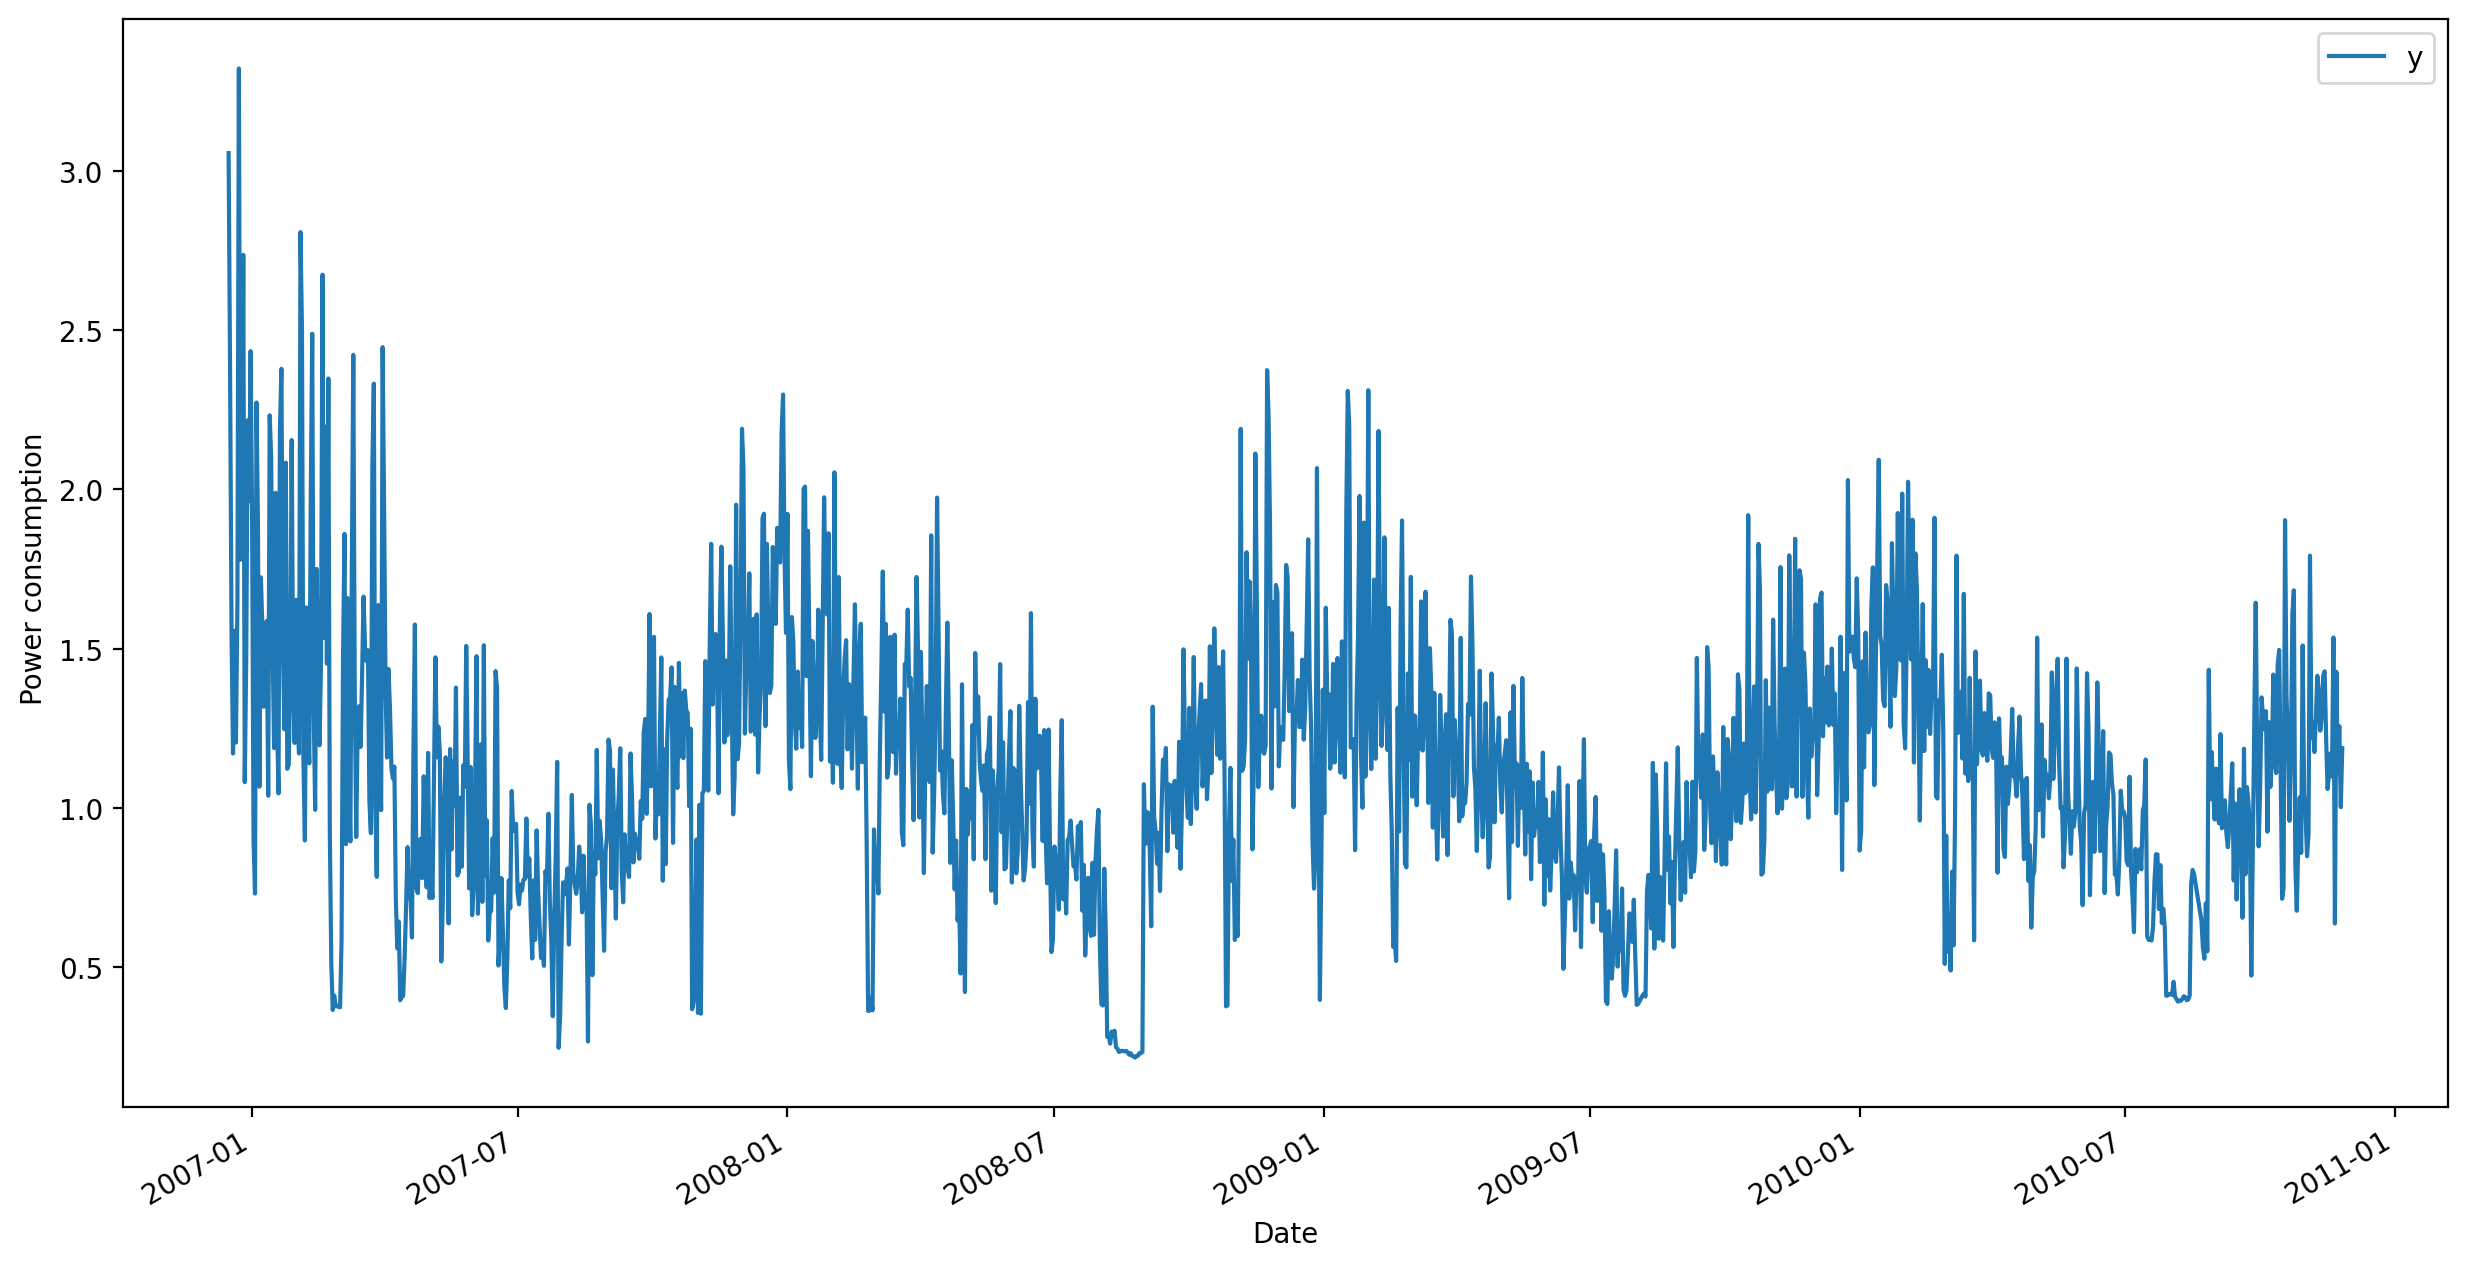

In [24]:
# намалюємо графік наших даних
ax = df_prop.set_index('ds').plot(figsize=(15, 8))
ax.set_ylabel('Power consumption ')
ax.set_xlabel('Date')

plt.show()

In [27]:

model = Prophet(interval_width=0.8)

In [29]:
model.fit(df_prop)

16:11:46 - cmdstanpy - INFO - Chain [1] start processing
16:11:46 - cmdstanpy - INFO - Chain [1] done processing
16:11:46 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6
Optimization terminated abnormally. Falling back to Newton.
16:11:46 - cmdstanpy - INFO - Chain [1] start processing
16:11:46 - cmdstanpy - INFO - Chain [1] done processing
16:11:46 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6


RuntimeError: Error during optimization! Command '/Users/nazarii_mozol/projects/studing/Machine-Learning/osx-venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin random seed=20488 data file=/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/tmpgxa8x1ms/ds_lg9n6.json init=/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/tmpgxa8x1ms/p4mb66ge.json output file=/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/tmpgxa8x1ms/prophet_modelpr3e3cvr/prophet_model-20230613161146.csv method=optimize algorithm=newton iter=10000' failed: console log output:

dyld[73219]: Library not loaded: @rpath/libtbb.dylib
  Referenced from: <0D3B4A3F-CF34-3DCB-835E-A6521D1D6A3F> /Users/nazarii_mozol/projects/studing/Machine-Learning/osx-venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin
  Reason: tried: '/private/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/pip-install-7t6oim_a/prophet_e086caab24ab49d898cbb11aca6ce719/build/lib.macosx-13.4-arm64-cpython-311/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/pip-install-7t6oim_a/prophet_e086caab24ab49d898cbb11aca6ce719/build/lib.macosx-13.4-arm64-cpython-311/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/pip-install-7t6oim_a/prophet_e086caab24ab49d898cbb11aca6ce719/build/lib.macosx-13.4-arm64-cpython-311/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/pip-install-7t6oim_a/prophet_e086caab24ab49d898cbb11aca6ce719/build/lib.macosx-13.4-arm64-cpython-311/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/pip-install-7t6oim_a/prophet_e086caab24ab49d898cbb11aca6ce719/build/lib.macosx-13.4-arm64-cpython-311/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/pip-install-7t6oim_a/prophet_e086caab24ab49d898cbb11aca6ce719/build/lib.macosx-13.4-arm64-cpython-311/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/pip-install-7t6oim_a/prophet_e086caab24ab49d898cbb11aca6ce719/build/lib.macosx-13.4-arm64-cpython-311/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/l5/hh08yprn4dsbqwfsjk4kb6zr0000gn/T/pip-install-7t6oim_a/prophet_e086caab24ab49d898cbb11aca6ce719/build/lib.macosx-13.4-arm64-cpython-311/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/usr/local/lib/libtbb.dylib' (no such file), '/usr/lib/libtbb.dylib' (no such file, not in dyld cache)


In [ ]:
# import cmdstanpy
# cmdstanpy.install_cmdstan(overwrite=True, compiler=True, dir=<path/to/cmdstan>)


In [43]:
# df_real.reset_index(inplace=True)
# #df_real.values
# df_real

Date  Total_power
0    2006-12-16     3.056187
1    2006-12-17     2.365602
2    2006-12-18     1.543069
3    2006-12-19     1.170682
4    2006-12-20     1.556785
...         ...          ...
1428 2010-11-22     1.427137
1429 2010-11-23     1.106567
1430 2010-11-24     1.256433
1431 2010-11-25     1.002206
1432 2010-11-26     1.187344

[1433 rows x 2 columns]

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

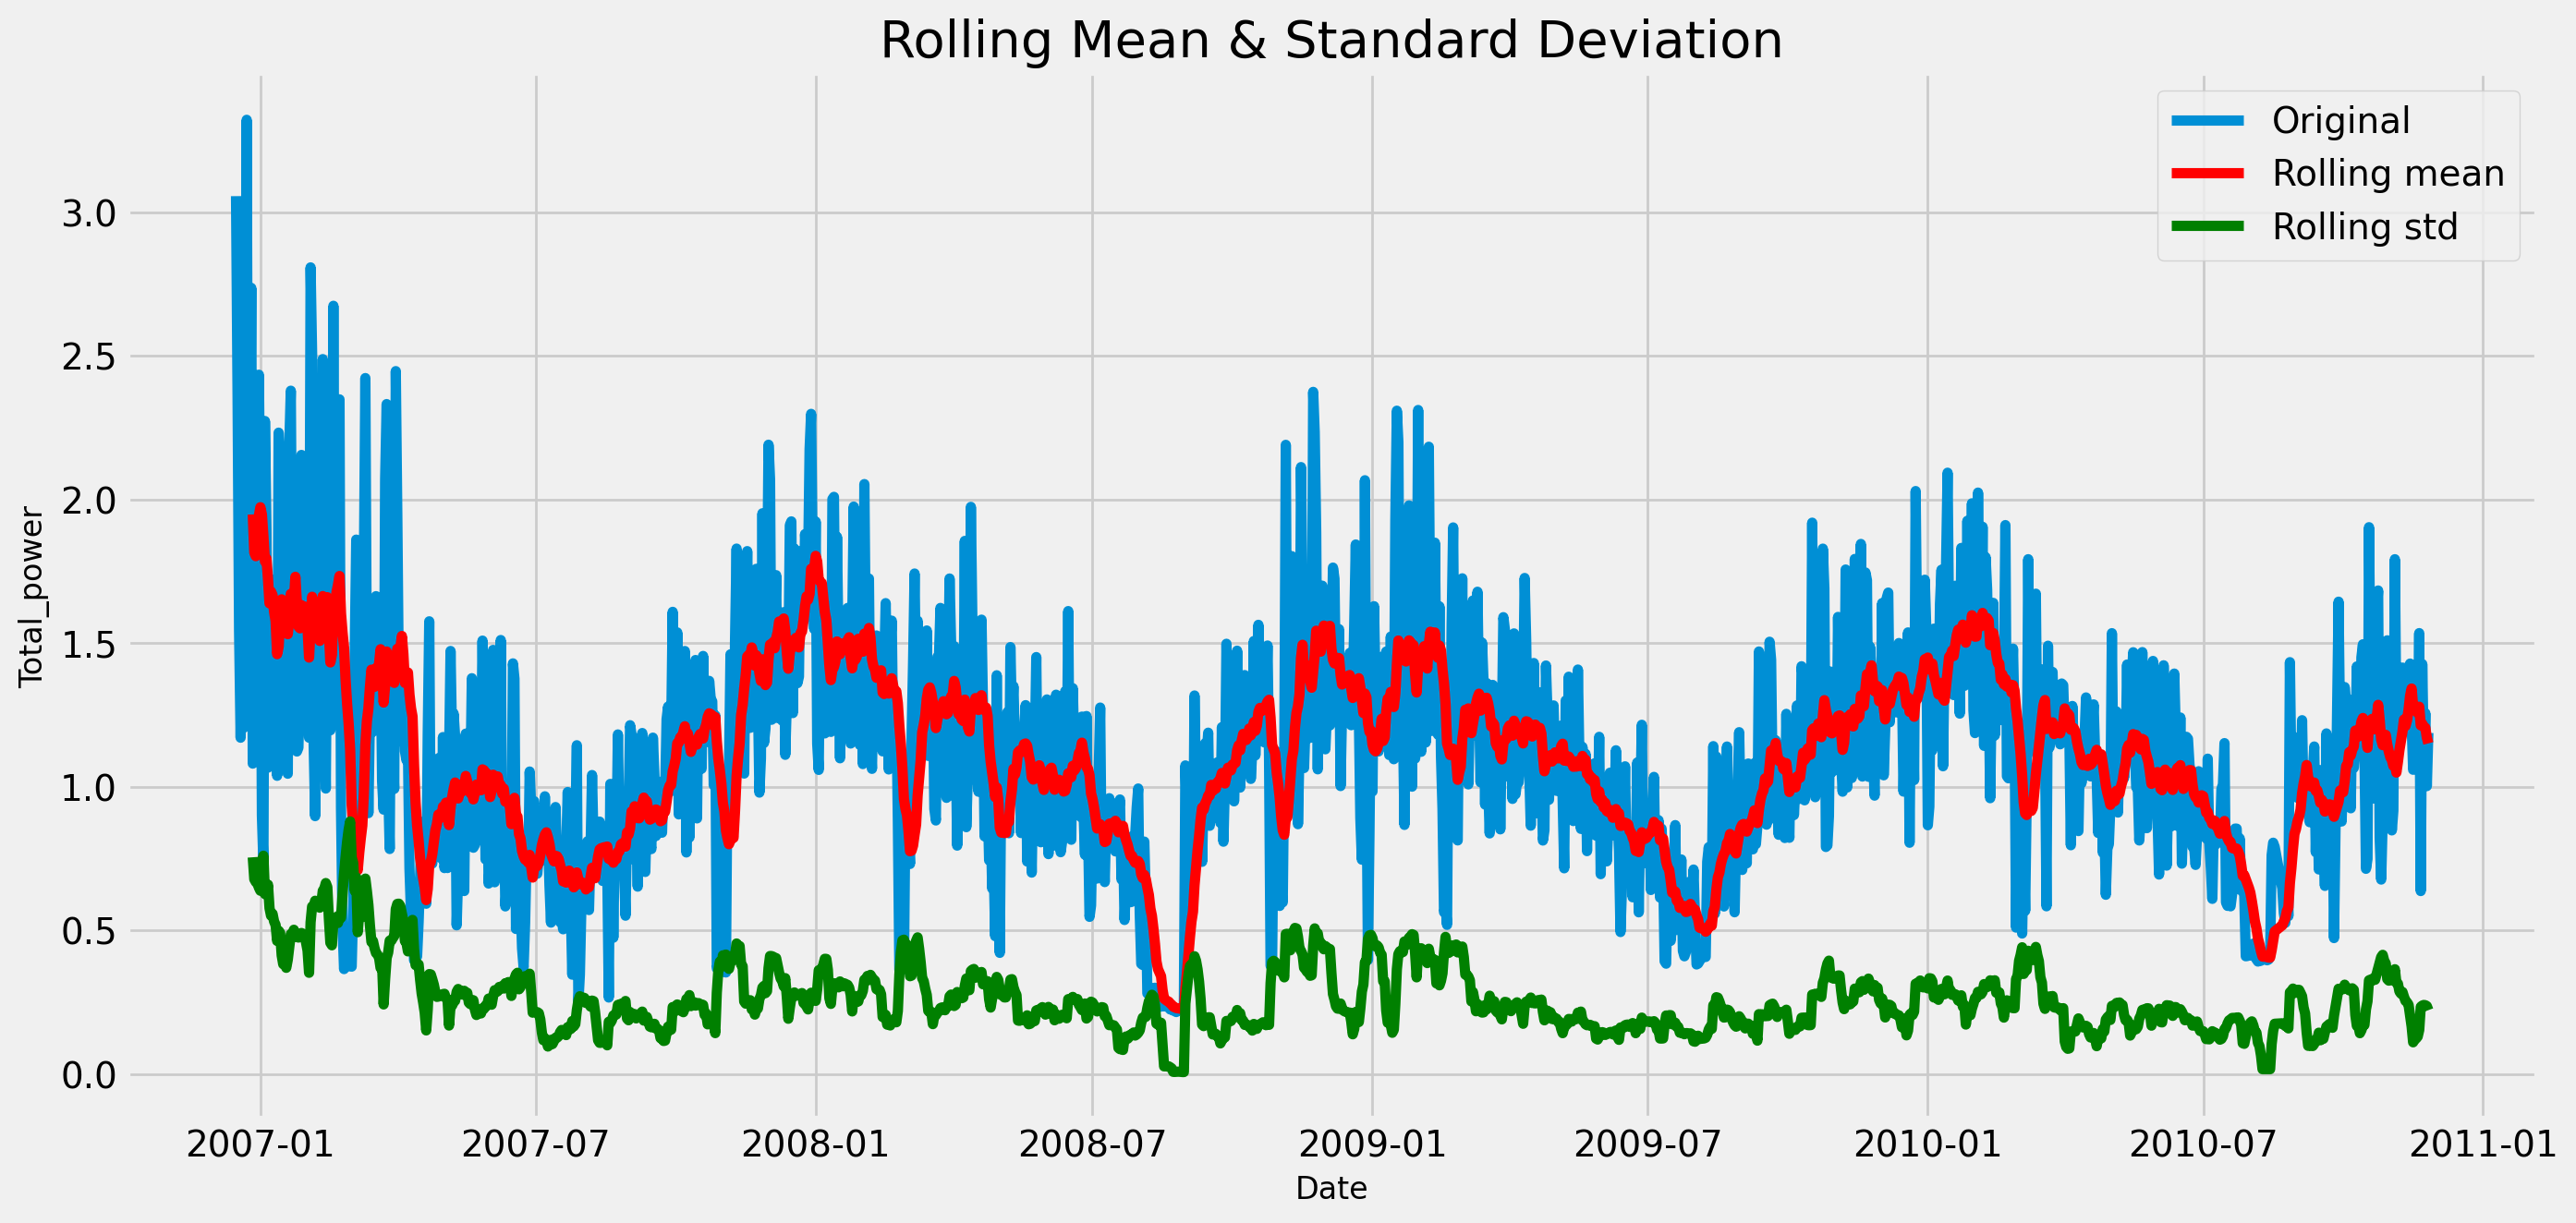

In [49]:
plt.figure(figsize=(15,7))
plt.plot(df_real["Total_power"], label='Original')
plt.plot(df_real["Total_power"].rolling(window=12).mean(), color='red', label='Rolling mean')
plt.plot(df_real["Total_power"].rolling(window=12).std(), color='green', label='Rolling std')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total_power', fontsize=12)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [50]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
   

In [51]:
ADF_test(df_real)

Results of Dickey-Fuller Test:
Test Statistic                   -3.729392
p-value                           0.003718
Lags Used                        22.000000
Number of Observations Used    1410.000000
Critical Value (1%)              -3.434996
Critical Value (5%)              -2.863592
Critical Value (10%)             -2.567862
dtype: float64


In [76]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
 
trend, seasonal, residual = seasonal_decompose(df_real)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [92]:
df_real.index.dtype

dtype('<M8[ns]')

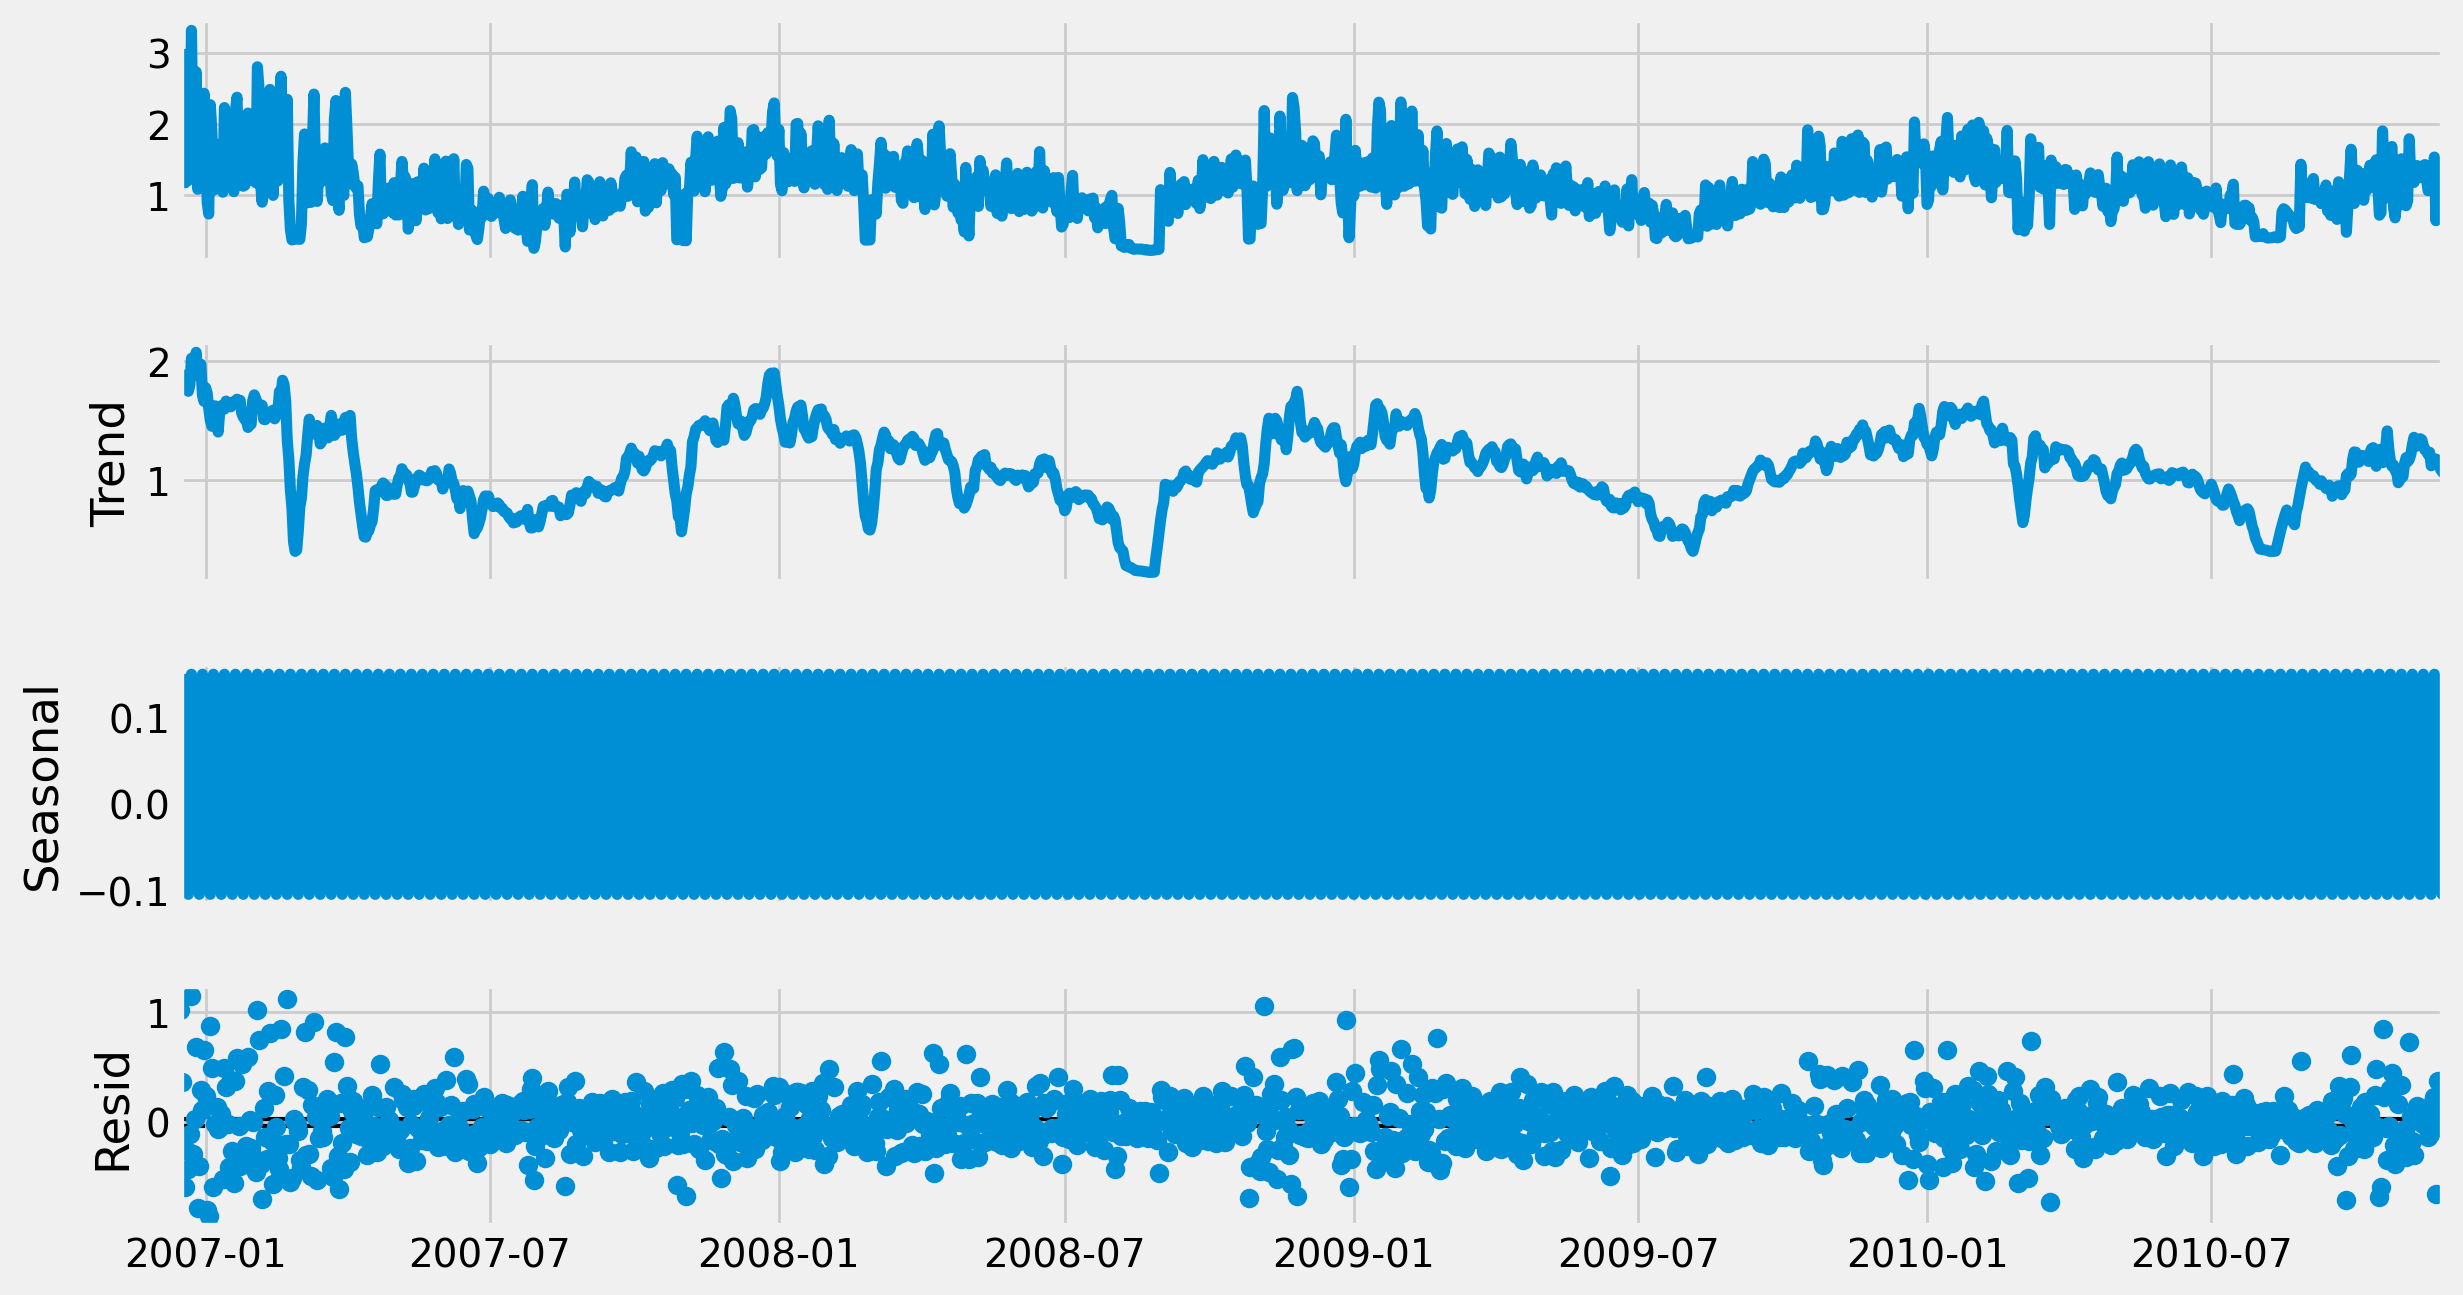

In [114]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
 
trend, seasonal, residual = seasonal_decompose(df_real)

In [6]:
df_real
df_real.reset_index(inplace=True)

In [7]:
df_real
date = pd.DatetimeIndex(df_real['Date'])
df_real.drop(columns='Date', inplace=True)
df_real.set_index(date, inplace=True)
df_real.index.name = 'Date'
df_real.dtypes

Total_power    float64
dtype: object

In [8]:
df_real=df_real.asfreq('d')

ValueError: cannot reindex on an axis with duplicate labels

In [95]:
df_real.index

DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='Date', length=1442, freq='D')

In [101]:
df_real['Total_power']=df_real['Total_power'].interpolate(method='time')

In [103]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total_power  1442 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


In [2]:
train_data = df_real['Total_power'][:int(len(df)*0.8)]
test_data = df_real['Total_power'][int(len(df)*0.8):]


NameError: name 'df_real' is not defined